# Set-up

## Imports

In [91]:
import sys
import os
sys.path.append(os.path.abspath('..')) # for importing from python files not in the same directory

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm

from utils import plot_components, month_to_season, functional_norm, normalize_curves

colors = sns.color_palette("deep")
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [92]:
n_comp = 5
n_runs = 1000
train_years = ['2021', '2022']
test_years = ['2023']

# arrays_path = f'data/3_output/nmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs.npz'
arrays_path = f"../data/3_output/pennmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs_{'_'.join(train_years)}.npz"
models_path = arrays_path.replace('.npz', '.pkl')

## Functions

# Main

## Deconvolve load and compute consumption per sectors

In [93]:
input_df = pd.read_csv(f"../data/2_processed/daily_curves_Italy.csv", index_col=0)
# Convert everything in GWh
input_df = input_df / 1000
pattern = r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$'
unit_info = input_df.index.str.extract(pattern).set_index(input_df.index)
unit_info['season'] = unit_info.month.astype(int).map(month_to_season)
df = pd.concat([input_df, unit_info], axis=1)
select_period_train = df.year.isin(train_years)
select_period_test = df.year.isin(test_years)
df = df.loc[select_period_train | select_period_test, :]
unit_info = unit_info.loc[select_period_train | select_period_test, :]
unit_info_train = unit_info.loc[select_period_train, :]
unit_info_test = unit_info.loc[select_period_test, :]
df_train = df.loc[select_period_train, :]
df_test = df.loc[select_period_test, :]
print(len(df_train))
df_train.head(3)

730


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,region,year,month,daytype,season
Italy_2021-01-01_Holiday,24.375000,23.142999,21.418001,20.136000,19.257999,19.473999,20.382000,21.137000,21.204001,22.809999,...,30.031000,28.681,27.158999,24.913000,22.807000,Italy,2021,01,Holiday,Winter
Italy_2021-01-02_Saturday,22.807000,21.146000,20.085000,19.431001,19.543000,20.095000,22.104000,23.960001,25.809999,28.031999,...,34.347000,31.864,29.392999,26.308999,23.326001,Italy,2021,01,Saturday,Winter
Italy_2021-01-03_Holiday,23.326001,21.322000,20.397999,19.543001,19.229000,19.879000,21.032999,22.168000,23.240000,25.000999,...,32.547001,30.280,28.256999,25.917000,23.235001,Italy,2021,01,Holiday,Winter


In [94]:
# Load the arrays from the .npz file
data = np.load(arrays_path)
with open(models_path, 'rb') as file:
    models = pickle.load(file)
# Access the arrays
S_results = data['S_results']
Ctrain_results = data['C_results']
iterations = data['iterations']
loss_nmf = data['loss_nmf']
loss_constraint_c = data['loss_constraint_c']
loss_constraint_s = data['loss_constraint_s']

n_runs = S_results.shape[-1]

In [95]:
X_unnorm_train = df_train.drop(unit_info_train.columns, axis=1)
X_unnorm_test = df_test.drop(unit_info_test.columns, axis=1)
X_unnorm_train_test = pd.concat([X_unnorm_train, X_unnorm_test])

unit_info_train_test = pd.concat([unit_info_train, unit_info_test])

h = 24 / (X_unnorm_train_test.shape[1]-1)

norm_X_train_test = X_unnorm_train_test.apply(lambda row: functional_norm(row, h), axis=1, raw=True)
norm_X_train = norm_X_train_test[unit_info_train_test.year.isin(train_years)]
norm_X_test = norm_X_train_test[unit_info_train_test.year.isin(test_years)]

curves_comp = {}

X_test = df_test.drop(unit_info_test.columns, axis=1)
X_test = normalize_curves(X_test)

p = X_unnorm_train.shape[1]

# Matrix D for computing functional L^1-norm vectorised
D = np.ones(p)
D[0] = 0.5
D[-1] = 0.5
h = 24 / (p-1)
D = h * D

In [96]:
# Adding the predicted concentrations to the fitted concentrations
Cpred_results = np.zeros((len(X_unnorm_test), n_comp, n_runs))

print(f"Estimating the sources concentrations in the test data for the {n_runs} runs...")
for run, model in enumerate(tqdm(models)):
    Cpred_results[..., run] = model.transform(X_test)
print("Done.")

print("Disaggregating the load per component...")
C_results = np.concatenate((Ctrain_results, Cpred_results), axis=0)
n_days = C_results.shape[0]
norms = norm_X_train_test.values.reshape(n_days, 1, 1, 1)
load = norms * C_results[..., np.newaxis, :] * np.stack([S_results] * n_days, axis=0)

# Here we reshape normload so that we have run changing first, then, hour and finally unit
load = pd.DataFrame(load.transpose((0, 3, 2, 1)).reshape((n_days * n_runs * p, n_comp)), index=np.repeat(norm_X_train_test.index, n_runs * p), columns=[f'Component {k+1}' for k in range(n_comp)])
load['run'] = np.tile(np.repeat(np.arange(n_runs), p), n_days)
load['hour'] = np.tile(X_test.columns.astype(int), n_runs * n_days)
load['Domestico'] = load['Component 1'] + load['Component 2']
load['Industria'] = load['Component 3']
load['Servizi'] = load['Component 4'] + load['Component 5']
print("Done.")

# Compute functional norm of each day for each run
print("Computing the sectors profiles by normalizing the disaggregated load...")
sectors = ['Domestico', 'Industria', 'Servizi']
norms = load.reset_index().groupby(['index', 'run'], as_index=False, sort=False)[sectors].agg(lambda a: a.dot(D))
profiles = load.drop([f'Component {k+1}' for k in range(n_comp)], axis=1)
profiles[sectors] = profiles[sectors] /  np.repeat(norms[sectors], repeats=p, axis=0)
profiles[unit_info.columns] = np.repeat(unit_info_train_test, repeats=p*n_runs, axis=0)
print("Done.")
profiles

Estimating the sources concentrations in the test data for the 159 runs...


100%|██████████| 159/159 [00:20<00:00,  7.73it/s]


Done.
Disaggregating the load per component...
Done.
Computing the sectors profiles by normalizing the disaggregated load...
Done.


,run,hour,Domestico,Industria,Servizi,region,year,month,daytype,season
Italy_2021-01-01_Holiday,0,0,0.038520,0.024586,0.040607,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,1,0.035306,0.023068,0.037793,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,2,0.033218,0.022667,0.035808,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,3,0.032289,0.022750,0.034488,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,4,0.032192,0.023340,0.033779,Italy,2021,01,Holiday,Winter
...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,158,20,0.055446,0.043712,0.044238,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,21,0.049896,0.041589,0.043291,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,22,0.043855,0.037180,0.042948,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,23,0.038251,0.034045,0.041057,Italy,2023,12,Holiday,Fall


In [179]:
df_list = []
for b in tqdm(range(n_runs)):
    C = C_results[..., b]

    consumptions = (norm_X_train_test.to_numpy()[:, np.newaxis] * C)
    consumptions = pd.DataFrame(consumptions, columns=[f'Component {k + 1}' for k in range(n_comp)], index=X_unnorm_train_test.index)
    consumptions['date'] = consumptions.index.str.split('_').str[1]
    consumptions = pd.concat([consumptions, unit_info_train_test], axis=1)

    consumptions['run'] = b

    df_list.append(consumptions)

day_df = pd.concat(df_list).sort_values(['date', 'run']) # Sort to recover the time order
day_df

100%|██████████| 159/159 [00:00<00:00, 699.38it/s]


,Component 1,Component 2,Component 3,Component 4,Component 5,date,region,year,month,daytype,season,norm,run
Italy_2021-01-01_Holiday,90.252445,58.373551,1.528186,174.236262,273.272953,2021-01-01,Italy,2021,01,Holiday,Winter,597.368996,0
Italy_2021-01-01_Holiday,95.102180,59.651024,21.184289,209.456675,212.243063,2021-01-01,Italy,2021,01,Holiday,Winter,597.368996,1
Italy_2021-01-01_Holiday,141.065964,55.890849,10.093153,168.735025,222.066888,2021-01-01,Italy,2021,01,Holiday,Winter,597.368996,2
Italy_2021-01-01_Holiday,177.518382,180.638627,15.986597,153.572886,69.592221,2021-01-01,Italy,2021,01,Holiday,Winter,597.368996,3
Italy_2021-01-01_Holiday,173.721250,83.427595,4.306006,196.728087,139.808469,2021-01-01,Italy,2021,01,Holiday,Winter,597.368996,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,136.866586,125.292843,15.402972,130.039564,195.810256,2023-12-31,Italy,2023,12,Holiday,Fall,602.807502,154
Italy_2023-12-31_Holiday,201.378421,125.586180,24.298393,123.343699,128.537915,2023-12-31,Italy,2023,12,Holiday,Fall,602.807502,155
Italy_2023-12-31_Holiday,140.535113,161.860268,27.263345,81.881220,191.605792,2023-12-31,Italy,2023,12,Holiday,Fall,602.807502,156
Italy_2023-12-31_Holiday,14.819322,196.010921,29.535778,72.879826,290.052241,2023-12-31,Italy,2023,12,Holiday,Fall,602.807502,157


In [98]:
month_df = day_df.groupby(['region', 'year', 'month', 'run'], as_index=False, sort=False)[[f'Component {k+1}' for k in range(n_comp)]].sum()
month_df

,region,year,month,run,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2021,01,0,4370.137051,2764.594307,11925.582556,3805.259204,4228.472057
1,Italy,2021,01,1,2452.427933,4663.551014,11895.826326,2699.597949,5383.409981
2,Italy,2021,01,2,3187.114657,3865.672723,11903.711636,2254.427006,5875.570539
3,Italy,2021,01,3,4379.276262,2708.738523,11917.746313,2202.335321,5877.004598
4,Italy,2021,01,4,2936.584129,4170.457927,11914.179520,2908.872946,5157.903770
...,...,...,...,...,...,...,...,...,...
5719,Italy,2023,12,154,2112.195383,4146.656051,10614.344669,3704.831132,4236.957707
5720,Italy,2023,12,155,3882.186489,2356.853438,10306.547140,2572.659432,5698.115927
5721,Italy,2023,12,156,1901.138897,4325.223561,10421.290973,3837.875108,4330.591134
5722,Italy,2023,12,157,1265.827019,4657.666889,11122.131512,3750.409141,4020.393712


In [124]:
year_df = month_df.groupby(['region', 'year', 'run'], as_index=False)[[f'Component {k+1}' for k in range(n_comp)]].sum()
year_df

,region,year,run,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2021,0,30382.533019,40581.758123,150206.647801,46475.087327,50694.055855
1,Italy,2021,1,36139.360711,34766.428447,150177.343283,47201.973178,50044.822677
2,Italy,2021,2,36923.595914,34162.009043,150045.286210,49759.498930,47441.414862
3,Italy,2021,3,35135.811960,35941.830417,150297.375558,45411.856287,51510.939264
4,Italy,2021,4,38295.931769,32805.754304,150155.357092,54188.415316,42845.327809
...,...,...,...,...,...,...,...,...
472,Italy,2023,154,33872.933461,31876.589648,148928.282514,47945.492700,45316.167432
473,Italy,2023,155,32160.864838,32183.612270,146259.110559,46202.332056,51167.381791
474,Italy,2023,156,32363.195225,31999.290927,146952.400594,49827.110025,46830.050019
475,Italy,2023,157,30172.280378,37671.731962,147688.632897,44482.247585,47948.828612


In [125]:
# Y_train = pd.read_pickle('data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(train_years)))
# Y_test = pd.read_pickle('data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(test_years)))
# Y = pd.concat([Y_train, Y_test], axis=0).sort_index()
Y = pd.read_pickle('../data/2_processed/PenNMF/Y.pkl')
Y

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,6578.069013,12076.214575,8758.839428
2020-02-01,5527.985114,12490.529300,7644.235592
2020-03-01,6397.951558,10704.954781,6622.130700
2020-04-01,5700.031442,8660.806370,5383.390680
2020-05-01,4977.937414,11658.651789,6011.084788
2020-06-01,4910.926859,11869.539002,7233.085663
2020-07-01,6107.741032,13094.183037,9521.393403
2020-08-01,7009.210582,8879.384386,9913.436574
2020-09-01,5157.447797,12777.718546,8433.093670


In [126]:
Y_pred = month_df.copy()
Y_pred['Domestico'] = Y_pred['Component 1'] + Y_pred['Component 2']
Y_pred['Industria'] = Y_pred['Component 3']
Y_pred['Servizi'] = Y_pred['Component 4'] + Y_pred['Component 5']
Y_pred.drop(columns=[f'Component {k+1}' for k in range(n_comp)], inplace=True)
Y_pred = Y_pred.groupby(['year', 'month', 'run'], as_index=False).sum().drop('region', axis=1)
Y_pred['date'] = pd.to_datetime(Y_pred['year'].astype(str) + '-' + Y_pred['month'], format='%Y-%m')
Y_pred.drop(columns=['year', 'month'], inplace=True)
# Set the 'date' column as the index
Y_pred.set_index('date', inplace=True)
Y_pred

,run,Domestico,Industria,Servizi
date,,,,
2021-01-01,0,7134.731358,11925.582556,8033.731262
2021-01-01,1,7115.978946,11895.826326,8083.007930
2021-01-01,2,7052.787379,11903.711636,8129.997546
2021-01-01,3,7088.014786,11917.746313,8079.339919
2021-01-01,4,7107.042056,11914.179520,8066.776716
...,...,...,...,...
2023-12-01,154,6258.851435,10614.344669,7941.788839
2023-12-01,155,6239.039927,10306.547140,8270.775360
2023-12-01,156,6226.362458,10421.290973,8168.466241


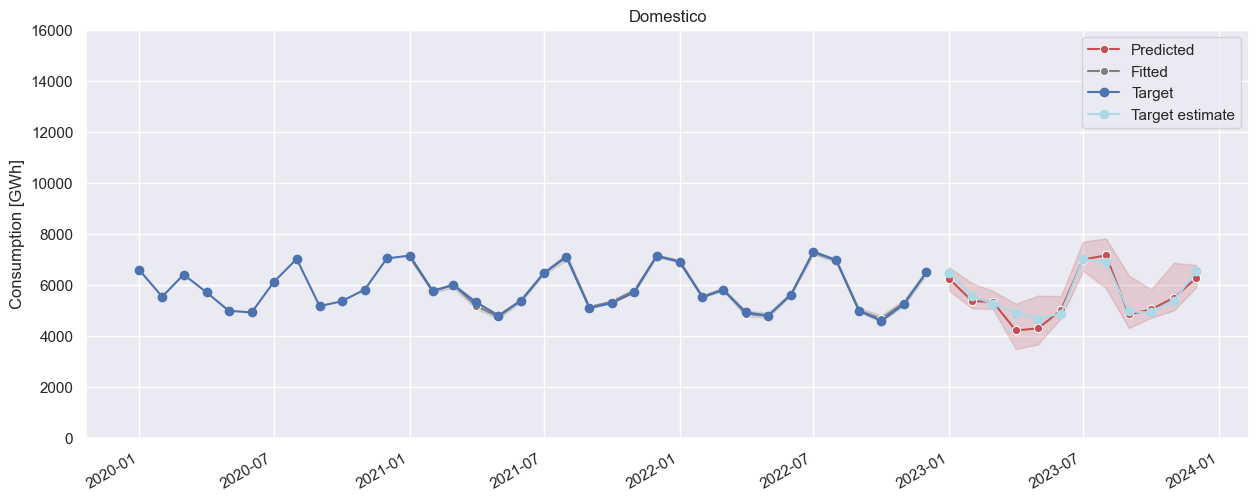

In [127]:
# Define the sector to plot
sector = 'Domestico'

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

Y.loc[Y.index.year < 2023, sector].plot(marker='o', color=colors[0], label='Target', ax=ax)
Y.loc[Y.index.year == 2023, sector].plot(marker='o', color='lightblue', label='Target estimate', ax=ax)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')
ax.set_xlabel(None)
ax.set_title(sector)
ax.legend()

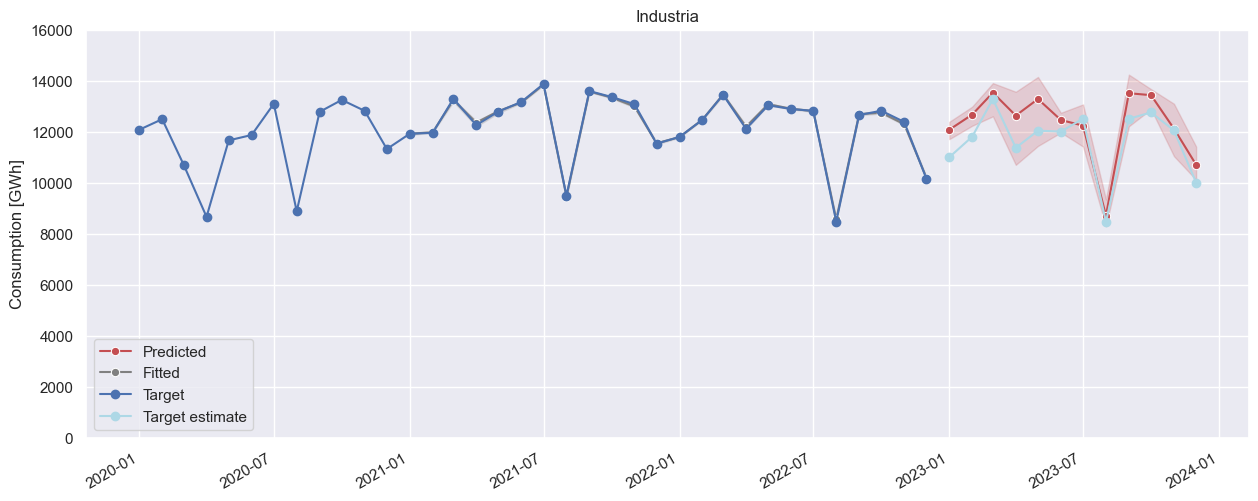

In [128]:
# Define the sector to plot
sector = 'Industria'

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

# Plot the target data using pandas' plot method
Y.loc[Y.index.year < 2023, sector].plot(marker='o', color=colors[0], label='Target', ax=ax)
# Plot the target data using pandas' plot method
Y.loc[Y.index.year == 2023, sector].plot(marker='o', color='lightblue', label='Target estimate', ax=ax)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')
ax.set_xlabel(None)
ax.set_title(sector)
ax.legend()

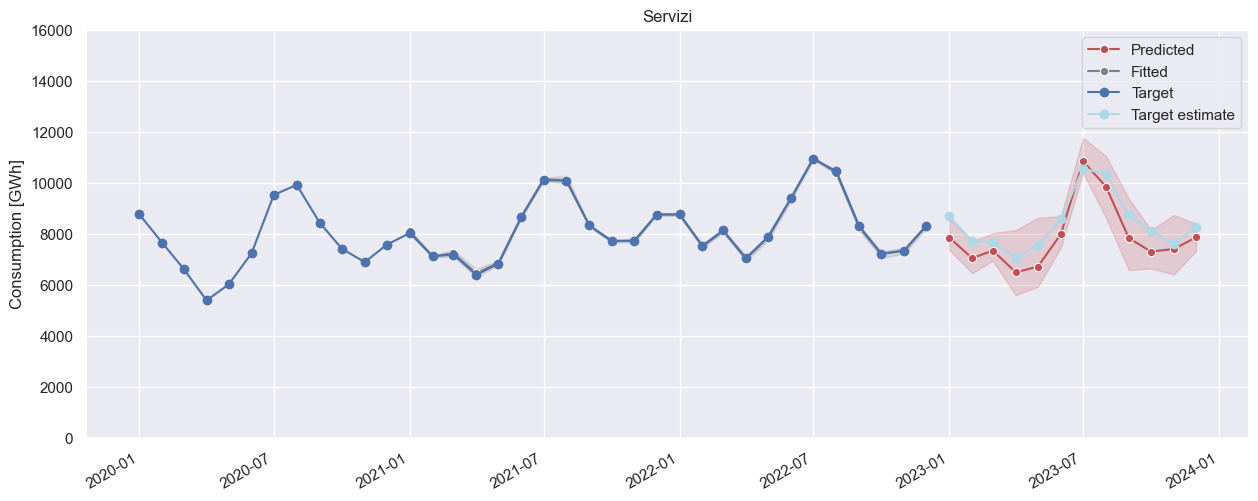

In [119]:
# Define the sector to plot
sector = 'Servizi'

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    marker='o'
)

# Plot the target data using pandas' plot method
Y.loc[Y.index.year < 2023, sector].plot(marker='o', color=colors[0], label='Target', ax=ax)
# Plot the target data using pandas' plot method
Y.loc[Y.index.year == 2023, sector].plot(marker='o', color='lightblue', label='Target estimate', ax=ax)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')
ax.set_xlabel(None)
ax.set_title(sector)
ax.legend()

In [120]:
Y_pred.to_pickle('../data/3_output/month_pred/double_constraint/Y_pred_train_{}_test_{}.pkl'.format('_'.join(train_years), '_'.join(test_years)))

In [129]:
(Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index().groupby('date', as_index=False)[sectors].mean().set_index('date') - Y[Y.index.year.astype(str).isin(test_years)]).abs().mean()

Domestico    216.269430
Industria    676.249007
Servizi      572.609259
dtype: float64

## Retrieve sectors profiles

In [130]:
profiles

,run,hour,Domestico,Industria,Servizi,region,year,month,daytype,season
Italy_2021-01-01_Holiday,0,0,0.038520,0.024586,0.040607,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,1,0.035306,0.023068,0.037793,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,2,0.033218,0.022667,0.035808,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,3,0.032289,0.022750,0.034488,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,4,0.032192,0.023340,0.033779,Italy,2021,01,Holiday,Winter
...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,158,20,0.055446,0.043712,0.044238,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,21,0.049896,0.041589,0.043291,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,22,0.043855,0.037180,0.042948,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,23,0.038251,0.034045,0.041057,Italy,2023,12,Holiday,Fall


In [135]:
profiles_ens = profiles.reset_index().groupby(unit_info.columns.to_list() + ['run', 'hour'], as_index=False, sort=False)[sectors].mean()
profiles_ens

,region,year,month,daytype,season,run,hour,Domestico,Industria,Servizi
0,Italy,2021,01,Holiday,Winter,0,0,0.032227,0.024586,0.041028
1,Italy,2021,01,Holiday,Winter,0,1,0.029197,0.023068,0.038148
2,Italy,2021,01,Holiday,Winter,0,2,0.027424,0.022667,0.036198
3,Italy,2021,01,Holiday,Winter,0,3,0.026765,0.022750,0.034961
4,Italy,2021,01,Holiday,Winter,0,4,0.027099,0.023340,0.034318
...,...,...,...,...,...,...,...,...,...,...
572395,Italy,2023,12,Monday,Fall,158,20,0.056124,0.043712,0.048365
572396,Italy,2023,12,Monday,Fall,158,21,0.049365,0.041589,0.046051
572397,Italy,2023,12,Monday,Fall,158,22,0.042850,0.037180,0.044383
572398,Italy,2023,12,Monday,Fall,158,23,0.037012,0.034045,0.041684


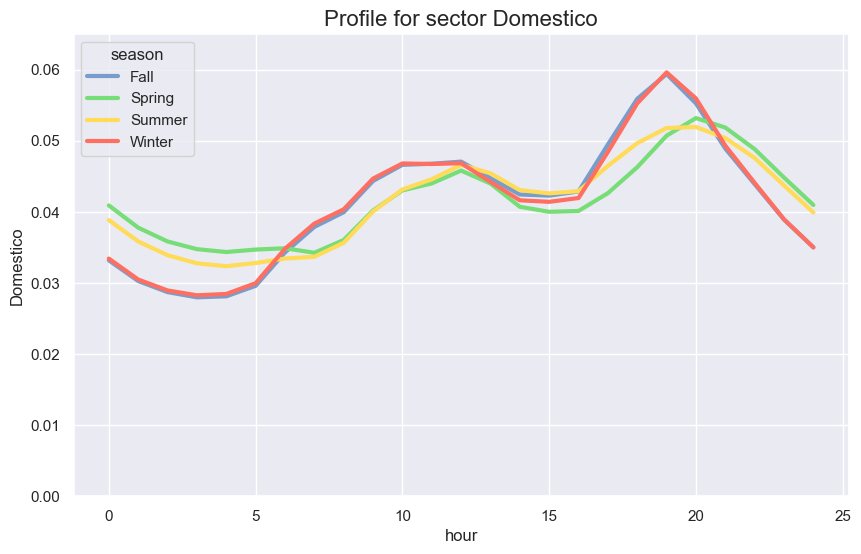

In [152]:
sector = 'Domestico'
hue = 'season'

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=profiles_ens.groupby([hue, 'hour', 'run'], as_index=False)[sector].mean(),
    x='hour',
    y=sector,
    errorbar=None,
    ax=ax,
    hue=hue,
    # marker='o',
    linewidth=3,
    palette=['#779ecb', '#77dd77', '#ffdb58', '#ff6f61']
)
# Set a title for the plot
ax.set_title(f'Profile for sector {sector}', fontsize=16)
ax.set_ylim((0,0.065))
plt.show()

<HR>

# TESTS

In [39]:
period = ["2022-02-01", "2022-02-07"]
test = comp_df.loc[(comp_df.index >= period[0]) & (comp_df.index <= period[1]), :]
test['Domestico'] = test['Component 1'] + test['Component 2']
test['Industria'] = test['Component 3']
test['Servizi'] = test['Component 4'] + test['Component 5']
test.sort_index()

,region,year,month,daytype,date,run,hour,Component 1,Component 2,Component 3,Component 4,Component 5,Domestico,Industria,Servizi
datetime,,,,,,,,,,,,,,,
2022-02-01,Italy,2022,01,Monday,2022-01-31,0,24,3.661064,5.508273,20.543094,1.662629,1.034168,9.169337,20.543094,2.696797
2022-02-01,Italy,2022,01,Monday,2022-01-31,1,24,4.437581,1.699595,23.036931,0.594597,1.960248,6.137176,23.036931,2.554845
2022-02-01,Italy,2022,01,Monday,2022-01-31,2,24,4.592626,7.798070,15.644535,3.414855,0.837813,12.390696,15.644535,4.252668
2022-02-01,Italy,2022,01,Monday,2022-01-31,3,24,3.162405,4.756865,21.551514,2.002606,0.242097,7.919270,21.551514,2.244703
2022-02-01,Italy,2022,01,Monday,2022-01-31,4,24,4.872258,4.789984,18.348288,3.395681,0.241990,9.662242,18.348288,3.637671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,Italy,2022,02,Monday,2022-02-07,214,0,2.917566,1.999431,18.489601,2.692212,0.229167,4.916997,18.489601,2.921379
2022-02-07,Italy,2022,02,Monday,2022-02-07,215,0,3.513297,1.872114,10.982649,6.093196,3.884482,5.385412,10.982649,9.977678
2022-02-07,Italy,2022,02,Monday,2022-02-07,216,0,4.439802,3.817201,11.844553,5.475817,0.461737,8.257003,11.844553,5.937554


In [172]:
# Extract the date part from the index
load['date_str'] = load.index.str[6:16]

# Convert the extracted date to a datetime object
load['date'] = pd.to_datetime(load['date_str'])

# Add the hour to the datetime column
load['datetime'] = load['date'] + pd.to_timedelta(load['hour'], unit='h')

# Drop the temporary 'date_str' and 'date' columns
load = load.drop(columns=['date_str', 'date'])
load['week'] = load['datetime'].we
load

,Component 1,Component 2,Component 3,Component 4,Component 5,run,hour,Domestico,Industria,Servizi,datetime
Italy_2021-01-01_Holiday,1.907786,3.817644,0.037561,7.707436,10.464464,0,0,5.725430,0.037561,18.171900,2021-01-01 00:00:00
Italy_2021-01-01_Holiday,1.663373,3.584444,0.035243,7.120362,9.791897,0,1,5.247818,0.035243,16.912259,2021-01-01 01:00:00
Italy_2021-01-01_Holiday,1.553471,3.383968,0.034631,6.827301,9.196600,0,2,4.937439,0.034631,16.023901,2021-01-01 02:00:00
Italy_2021-01-01_Holiday,1.537050,3.262194,0.034757,6.720212,8.713283,0,3,4.799244,0.034757,15.433495,2021-01-01 03:00:00
Italy_2021-01-01_Holiday,1.635777,3.149145,0.035658,6.696048,8.420195,0,4,4.784923,0.035658,15.116243,2021-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,4.193544,8.872251,0.679584,4.653541,10.923712,158,20,13.065794,0.679584,15.577253,2023-12-31 20:00:00
Italy_2023-12-31_Holiday,4.948739,6.809101,0.646584,4.255722,10.988167,158,21,11.757840,0.646584,15.243889,2023-12-31 21:00:00
Italy_2023-12-31_Holiday,4.903825,5.430606,0.578035,3.918371,11.204714,158,22,10.334431,0.578035,15.123085,2023-12-31 22:00:00
Italy_2023-12-31_Holiday,4.650080,4.363623,0.529301,3.572164,10.885074,158,23,9.013702,0.529301,14.457239,2023-12-31 23:00:00


<Axes: xlabel='datetime', ylabel='Domestico'>

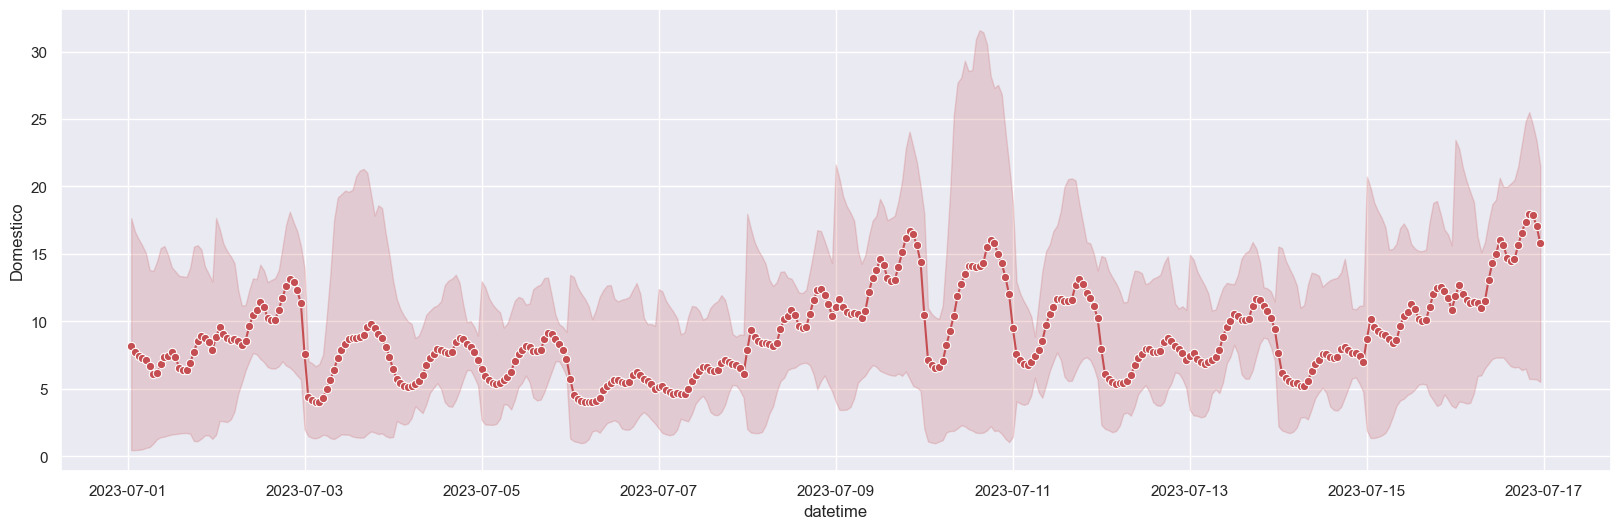

In [171]:
sector = 'Domestico'
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(
    data=load[(load.datetime > '2023-07-01') & (load.datetime < '2023-07-17')],
    x='datetime',
    y=sector,
    color=colors[3],
    errorbar='pi',
    ax=ax,
    marker='o'
)

In [184]:
week_df = day_df.copy()
week_df['week'] = pd.to_datetime(week_df.date).dt.to_period('W')
week_df['Domestico'] = week_df['Component 1'] + week_df['Component 2']
week_df['Industria'] = week_df['Component 3']
week_df['Servizi'] = week_df['Component 4'] + week_df['Component 5']
week_df = week_df.groupby(['week', 'run'], as_index=False)[sectors].sum()
week_df['week_start'] = week_df.week.dt.to_timestamp()
week_df

,week,run,Domestico,Industria,Servizi,week_start
0,2020-12-28/2021-01-03,0,454.594358,41.327016,1388.866802,2020-12-28
1,2020-12-28/2021-01-03,1,461.208326,83.426404,1339.787576,2020-12-28
2,2020-12-28/2021-01-03,2,746.608182,15.522605,1123.493385,2020-12-28
3,2020-12-28/2021-01-03,3,1139.986587,173.303628,570.481539,2020-12-28
4,2020-12-28/2021-01-03,4,927.014641,33.619723,924.859871,2020-12-28
...,...,...,...,...,...,...
24958,2023-12-25/2023-12-31,154,1734.342564,928.559661,1779.396683,2023-12-25
24959,2023-12-25/2023-12-31,155,1924.113872,1174.118145,1343.647414,2023-12-25
24960,2023-12-25/2023-12-31,156,1829.071042,1140.280055,1472.552037,2023-12-25
24961,2023-12-25/2023-12-31,157,1596.507910,825.858023,2020.280658,2023-12-25


In [ ]:
week_df['week_no'] = week_df['week'].

<Axes: xlabel='week_start', ylabel='Industria'>

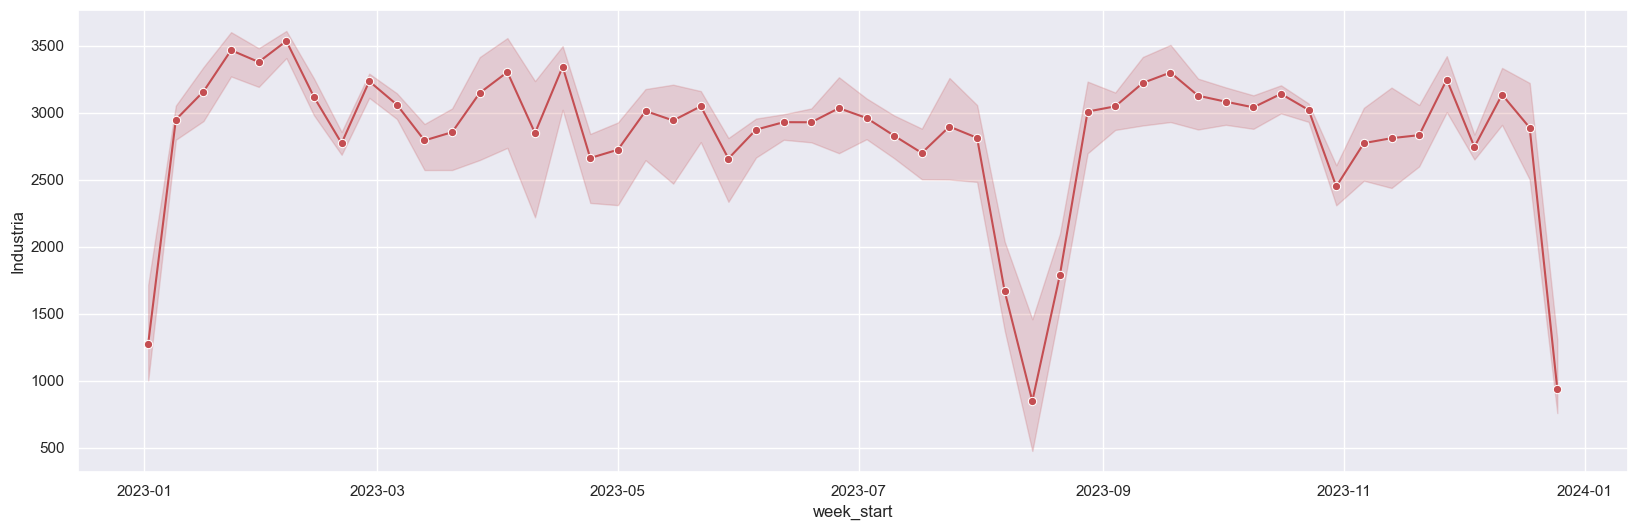

In [192]:
sector = 'Industria'
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(
    data=week_df[week_df.week_start.dt.year==2023],
    x='week_start',
    y=sector,
    color=colors[3],
    errorbar='pi',
    ax=ax,
    marker='o'
)

<Axes: xlabel='datetime', ylabel='Servizi'>

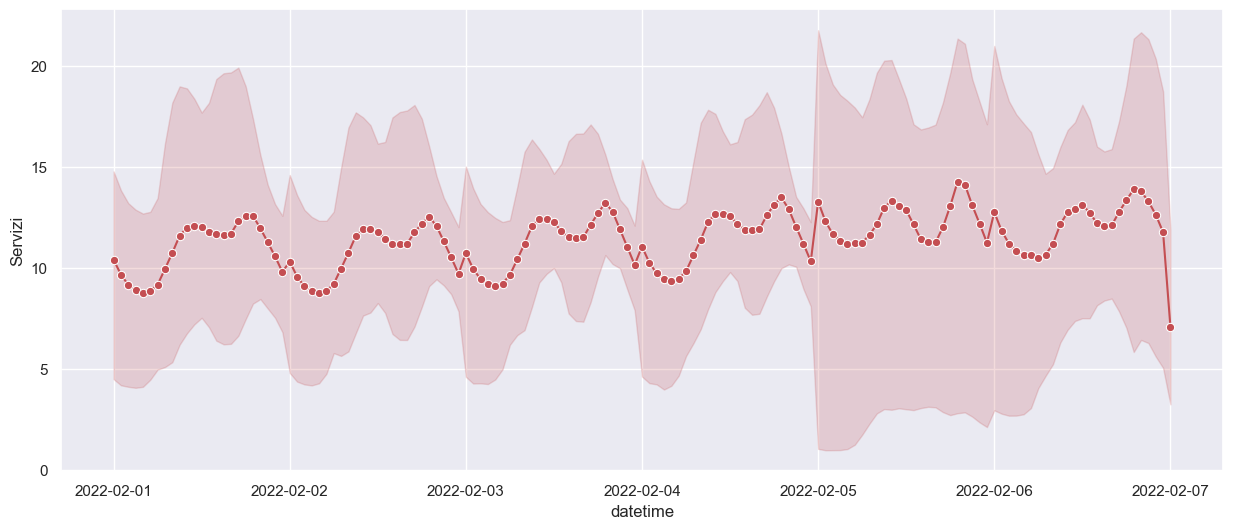

In [ ]:
sector = 'Servizi'
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(
    data=test.reset_index(),
    x='datetime',
    y=sector,
    color=colors[3],
    errorbar='pi',
    ax=ax,
    marker='o'
)

In [370]:
test = curves_comp['Component 1']
test

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,date,region,year,month,daytype,run
Italy_2021-01-01_Holiday,3.155008,2.808496,2.592716,2.461107,2.490856,2.781556,3.809492,4.595765,4.669520,5.471612,...,7.369435,6.064498,5.396595,4.685917,2021-01-01,Italy,2021,01,Holiday,0
Italy_2021-01-01_Holiday,1.171622,1.020984,0.979897,0.981108,1.063055,1.312091,2.215951,2.967413,3.208920,3.577194,...,4.131982,3.151554,2.568439,2.112266,2021-01-01,Italy,2021,01,Holiday,213
Italy_2021-01-01_Holiday,1.476429,1.270056,1.221876,1.228674,1.328208,1.619162,2.665501,3.422308,3.582618,3.966799,...,4.921599,3.627058,2.883163,2.300710,2021-01-01,Italy,2021,01,Holiday,210
Italy_2021-01-01_Holiday,4.087746,3.764382,3.576586,3.436655,3.422157,3.647118,4.209014,4.783918,5.500324,6.409856,...,8.133166,8.173577,7.757202,7.127091,2021-01-01,Italy,2021,01,Holiday,224
Italy_2021-01-01_Holiday,2.295808,2.132332,1.963226,1.823361,1.801598,2.018054,2.805699,3.848281,4.357968,5.135009,...,5.535886,5.154588,4.898795,4.535897,2021-01-01,Italy,2021,01,Holiday,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,3.408630,3.024115,2.891071,2.851576,2.989864,3.479325,5.145853,6.490040,6.987593,7.849145,...,9.599805,7.834575,6.685542,5.675028,2023-12-31,Italy,2023,12,Holiday,122
Italy_2023-12-31_Holiday,1.300327,1.147757,1.177098,1.260434,1.442592,1.904713,3.544510,5.196419,6.014702,6.440627,...,6.095638,4.635861,3.605613,2.906400,2023-12-31,Italy,2023,12,Holiday,153
Italy_2023-12-31_Holiday,2.147897,1.970639,1.937465,1.952615,2.089053,2.558544,4.176812,5.976465,7.056734,7.750692,...,7.438136,6.369282,5.457454,4.744599,2023-12-31,Italy,2023,12,Holiday,136
Italy_2023-12-31_Holiday,5.309321,4.744060,4.484401,4.395014,4.467908,4.766518,5.852586,6.558853,6.470625,7.048383,...,9.036669,6.935087,5.852109,4.904477,2023-12-31,Italy,2023,12,Holiday,14


In [371]:
test['totday'] = norm_X
test.sort_values('date')

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,date,region,year,month,daytype,run,totday
Italy_2021-01-01_Holiday,3.155008,2.808496,2.592716,2.461107,2.490856,2.781556,3.809492,4.595765,4.669520,5.471612,...,6.064498,5.396595,4.685917,2021-01-01,Italy,2021,01,Holiday,0,597.368996
Italy_2021-01-01_Holiday,5.407438,4.869319,4.665194,4.600102,4.669638,4.940061,5.793544,6.207338,6.351934,6.930907,...,7.875475,6.846932,5.891431,2021-01-01,Italy,2021,01,Holiday,200,597.368996
Italy_2021-01-01_Holiday,3.294786,2.918153,2.716189,2.602040,2.661899,3.006490,4.235306,5.151070,5.269080,6.072437,...,6.360420,5.538220,4.745632,2021-01-01,Italy,2021,01,Holiday,269,597.368996
Italy_2021-01-01_Holiday,2.789852,2.507863,2.342697,2.239150,2.282011,2.613612,3.739965,4.766120,5.193436,6.048976,...,6.360250,5.719548,5.056224,2021-01-01,Italy,2021,01,Holiday,2,597.368996
Italy_2021-01-01_Holiday,1.552306,1.392278,1.336342,1.343142,1.409135,1.599205,2.338690,3.061208,3.284859,3.457195,...,2.242035,1.707237,1.365522,2021-01-01,Italy,2021,01,Holiday,144,597.368996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,1.629531,1.409408,1.306264,1.264012,1.369464,1.792287,3.349374,4.814051,5.203542,5.937825,...,4.974246,4.143885,3.474978,2023-12-31,Italy,2023,12,Holiday,33,602.807502
Italy_2023-12-31_Holiday,4.810135,4.360097,4.065387,3.854912,3.844313,4.146241,5.125243,5.911078,6.223895,7.313124,...,8.778001,8.109069,7.264702,2023-12-31,Italy,2023,12,Holiday,128,602.807502
Italy_2023-12-31_Holiday,5.249971,4.709853,4.413174,4.309583,4.392057,4.716671,5.995163,7.093073,7.134899,7.737448,...,6.395260,5.315214,4.445259,2023-12-31,Italy,2023,12,Holiday,141,602.807502
Italy_2023-12-31_Holiday,2.530322,2.324839,2.256915,2.246191,2.363425,2.814916,4.369206,6.117311,7.141712,7.877758,...,6.632251,5.753090,5.045058,2023-12-31,Italy,2023,12,Holiday,31,602.807502


In [372]:
daily = day_df.copy()
daily['Domestico'] = daily['Component 1'] + daily['Component 2']
daily['Industria'] = daily['Component 3']
daily['Servizi'] = daily['Component 4'] + daily['Component 5']
daily

,region,year,month,date,daytype,run,Component 1,Component 2,Component 3,Component 4,Component 5,Domestico,Industria,Servizi
0,Italy,2021,01,2021-01-01,Holiday,0,133.668523,193.493695,31.223116,38.683320,111.909913,327.162218,31.223116,150.593233
1,Italy,2021,01,2021-01-01,Holiday,1,34.697057,146.107834,61.974173,156.544093,121.451809,180.804890,61.974173,277.995902
2,Italy,2021,01,2021-01-01,Holiday,2,139.385159,112.427393,6.230288,211.753529,41.581814,251.812552,6.230288,253.335343
3,Italy,2021,01,2021-01-01,Holiday,3,268.201784,43.341361,67.707270,66.783113,52.354801,311.543145,67.707270,119.137914
4,Italy,2021,01,2021-01-01,Holiday,4,34.178883,70.960887,16.468367,175.278698,217.617623,105.139770,16.468367,392.896320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296740,Italy,2023,12,2023-12-31,Holiday,266,140.101052,122.799140,19.654587,76.281396,150.351672,262.900192,19.654587,226.633068
296741,Italy,2023,12,2023-12-31,Holiday,267,111.075423,129.184905,10.589692,26.851451,215.793159,240.260327,10.589692,242.644610
296742,Italy,2023,12,2023-12-31,Holiday,268,139.194848,123.317353,22.468033,62.140179,167.680441,262.512202,22.468033,229.820620
296743,Italy,2023,12,2023-12-31,Holiday,269,175.924773,116.972386,37.581372,56.847973,135.865585,292.897160,37.581372,192.713558


<Axes: xlabel='date', ylabel='Industria'>

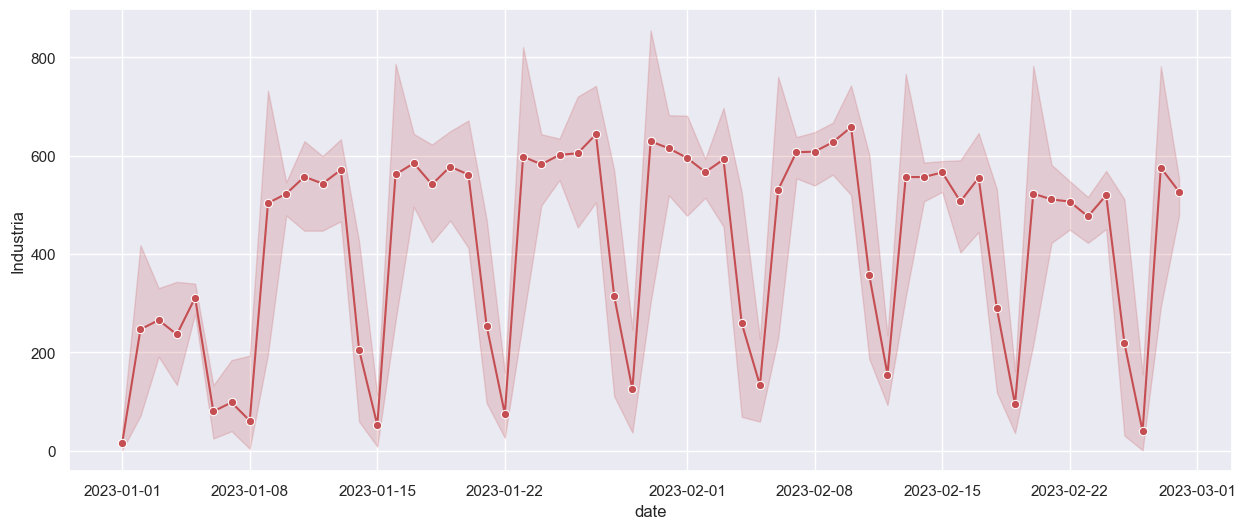

In [374]:
year = '2023'
months = ['01', '02']
sector = 'Industria'

fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=daily[daily.month.isin(months) & (daily.year==year)],
    x='date',
    y=sector,
    color=colors[3],
    errorbar='pi',
    ax=ax,
    marker='o'
)